# SIIM-ISIC Melanoma Classification
### Input

In [1]:
# image size:
# choose one between 256, 384, 512, 768
image_dim = 256

# competition data:
# choose between "2020" (only 2020 competition data) or "2019-2020" (2020 + 2019 competition data, including 2017 and 2018)
year_data = "2020"

#### 3rd place models:

|  Model      |  image_dim  |   year_data   |
|  :----:     |    :----:   |     :----:    |
|    1        |   256       |     "2020"    |
|    2        |   384       |     "2020"    |
|    3        |   512       |     "2020"    |
|    4        |   768       |     "2020"    |
|    5        |   256       |  "2019-2020"  |
|    6        |   384       |  "2019-2020"  |
|    7        |   512       |  "2019-2020"  |
|    8        |   768       |  "2019-2020"  |

### Parameters/Configuration Specification

In [2]:
# crop size for each original image size (in case you want to resize the images before the crop):
crop_size = {256: 250, 384: 370, 512: 500, 768: 750}

# net size for each original image size:
if year_data == "2020":
    net_size = {256: 248, 384: 370, 512: 500, 768: 750}
elif year_data == "2019-2020":
    net_size = {256: 250, 384: 370, 512: 500, 768: 750}

# hair augmentation for each original image size:
if year_data == "2020":
    hair_augm = {256: False, 384: False, 512: False, 768: False}
elif year_data == "2019-2020":
    hair_augm = {256: True, 384: True, 512: True, 768: False}
    
# epochs number for each original image size:
if year_data == "2020":
    epochs_num = {256: 13, 384: 15, 512: 15, 768: 15}
elif year_data == "2019-2020":
    epochs_num = {256: 25, 384: 25, 512: 12, 768: 10}

#pretrained weights:
model_weights = 'imagenet' # 'noisy-student'

# device
DEVICE = "TPU"

In [3]:
PARAMS = dict(
    # batch size:
    batch_size = 16,
    # image size:
    read_size = image_dim,
    crop_size = crop_size[image_dim],
    net_size = net_size[image_dim],
    
    # LEARNING RATE
    LR_START = 0.000003,
    LR_MAX = 0.000020,
    LR_MIN = 0.000001,
    LR_RAMPUP_EPOCHS  = 5,
    LR_SUSTAIN_EPOCHS = 0,
    LR_EXP_DECAY = 0.8,
    
    # EPOCHS:
    epochs = epochs_num[image_dim],
    
    # DATA AUGMENTATION
    rot = 180.0,
    shr = 1.5,
    hzoom = 6.0,
    wzoom = 6.0, 
    hshift = 6.0,
    wshift = 6.0,
    
    # COARSE DROPOUT
    DROP_FREQ = 0, # Frequency of drop / Between 0 and 1.
    DROP_CT = 0, # Number of squares to drop / Between 0 and 1.
    DROP_SIZE = 0, # Size of squares to drop / Between 0 and 1.
    
    # HAIR AUGMENTATION:
    hair_augm = hair_augm[image_dim],
    
    optimizer = 'Adam', # 'adam' or 'sgd'
    label_smooth_fac = 0.05,
    tta_steps =  25
)

### Install EfficientNet

In [4]:
! /opt/conda/bin/python3.7 -m pip install -q --upgrade pip
! pip install -q efficientnet

### Import required libraries

In [5]:
# import libraries
import os, random, re, math, time
random.seed(a=42)

from glob import glob
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets
import PIL

2023-02-07 20:12:28.602261: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-07 20:12:28.602401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Read the data

In [6]:
# base path for the competition data
BASEPATH = "../input/siim-isic-melanoma-classification"
# csv files for the competition data (train, test, sample submission)
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

# 2020 TFRecords
GCS_PATH = KaggleDatasets().get_gcs_path(f'melanoma-{image_dim}x{image_dim}')

# 2019 TFRecords
GCS_PATH_2019 = KaggleDatasets().get_gcs_path(f'isic2019-{image_dim}x{image_dim}')

In [7]:
# TRAIN files
if year_data == "2020":
    train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
elif year_data == "2019-2020":
    ## 2020 + 2019 (all, including 2017+2018):
    train_files = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
    train_files += tf.io.gfile.glob(GCS_PATH_2019 + '/train*.tfrec')
    train_files = np.sort(np.array(train_files)) # np.random.shuffle(files_train)


# TEST
files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

2023-02-07 20:12:34.972987: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-07 20:12:35.028169: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


### TPU configuration

In [8]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...


2023-02-07 20:12:35.185602: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-07 20:12:35.188336: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-07 20:12:35.188436: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-07 20:12:35.188466: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c2c66d10dce0): /proc/driver/nvidia/version does not exist
2023-02-07 20:12:35.192562: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

TPU initialized
REPLICAS: 8


### Functions

In [9]:
# HAIR AUGMENTATION

# loading hairs images: 
GCS_PATH_hair_images = KaggleDatasets().get_gcs_path('melanoma-hairs')
hair_images = tf.io.gfile.glob(GCS_PATH_hair_images + '/*.png')
hair_images_tf=tf.convert_to_tensor(hair_images)

# the maximum number of hairs to augment in an image:
n_max= 20

# The hair images were originally designed for the 256x256 size, so they need to be scaled to use with images of different sizes.
# The scale factor is calculated according to the ratio between the image size and the hair images size (256):
if image_dim != 256:
    scale=tf.cast(PARAMS['crop_size']/256, dtype=tf.int32)

    
def hair_aug_tf(input_img, augment=True):
    
    if augment:
    
        # Copy the input image, so it won't be changed
        img = tf.identity(input_img)

        # Unnormalize: Returning the image from 0-1 to 0-255:
        img = tf.multiply(img, 255)

        # Randomly choose the number of hairs to augment (up to n_max)
        n_hairs = tf.random.uniform(shape=[], maxval=tf.constant(n_max)+1,dtype=tf.int32)

        im_height = tf.shape(img)[0]
        im_width = tf.shape(img)[1]

        if n_hairs == 0:
            # No hair augmentation - return the original image normalized to 0-1
            img = tf.multiply(img, 1/255)
            return img

        for _ in tf.range(n_hairs):

            # Randomly choose a hair image
            i = tf.random.uniform(shape=[], maxval=tf.shape(hair_images_tf)[0],dtype=tf.int32)
            fname = hair_images_tf[i]
            bits = tf.io.read_file(fname)
            hair = tf.image.decode_jpeg(bits)

            # Rescale the hair image to the right size
            if image_dim != 256:
                # new_height, new_width, _  = scale*tf.shape(hair)
                new_width = scale*tf.shape(hair)[1]
                new_height = scale*tf.shape(hair)[0]
                hair = tf.image.resize(hair, [new_height, new_width])

            # Random flips of the hair image
            hair = tf.image.random_flip_left_right(hair)
            hair = tf.image.random_flip_up_down(hair)

            # Random number of 90 degree rotations
            num_rotation = tf.random.uniform(shape=[], maxval=4,dtype=tf.int32)
            hair = tf.image.rot90(hair, k=num_rotation)

            # The hair image height and width (ignore the number of color channels)
            h_height = tf.shape(hair)[0]
            h_width = tf.shape(hair)[1]

            # The top left coord's of the region of interest (roi) where the augmentation will be performed
            roi_h0 = tf.random.uniform(shape=[], maxval=im_height - h_height + 1, dtype=tf.int32)
            roi_w0 = tf.random.uniform(shape=[], maxval=im_width - h_width + 1, dtype=tf.int32)

            # The region of interest
            roi = img[roi_h0:(roi_h0 + h_height), roi_w0:(roi_w0 + h_width)]  

            # Convert the hair image to grayscale (slice to remove the trainsparency channel)
            hair2gray = tf.image.rgb_to_grayscale(hair[:, :, :3])

            # Threshold:
            mask = hair2gray>10

            img_bg = tf.multiply(roi, tf.cast(tf.image.grayscale_to_rgb(~mask), dtype=tf.float32))
            hair_fg = tf.multiply(tf.cast(hair[:, :, :3], dtype=tf.int32), tf.cast(tf.image.grayscale_to_rgb(mask), dtype=tf.int32))

            dst = tf.add(img_bg, tf.cast(hair_fg, dtype=tf.float32))

            paddings = tf.stack([[roi_h0, im_height-(roi_h0 + h_height)], [roi_w0, im_width-(roi_w0 + h_width)],[0, 0]])
            # Pad dst with zeros to make it the same shape as image.
            dst_padded=tf.pad(dst, paddings, "CONSTANT")

            # Create a boolean mask with zeros at the pixels of the augmentation segment and ones everywhere else
            mask_img=tf.pad(tf.ones_like(dst), paddings, "CONSTANT")
            mask_img=~tf.cast(mask_img, dtype=tf.bool)

            # Make a hole in the original image at the location of the augmentation segment
            img_hole=tf.multiply(img, tf.cast(mask_img, dtype=tf.float32))

            # Inserting the augmentation segment in place of the hole
            img = tf.add(img_hole, dst_padded)

        # Normalize the image to [0,1]
        img = tf.multiply(img, 1/255)
        
        return img
    else:
        return input_img

2023-02-07 20:12:41.032469: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [10]:
# COARSE DROPOUT

def coarse_dropout(image, DIM=256, PROBABILITY = 0.75, CT = 8, SZ = 0.2):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        # COMPUTE SQUARE
        WIDTH = tf.cast( SZ*DIM,tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3]) 
        three = image[ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR
    image = tf.reshape(image,[DIM,DIM,3])
    return image

In [11]:
# FOCAL LOSS

def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return binary_focal_loss_fixed

In [12]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

In [13]:
def transform(image, cfg):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg["read_size"]
    XDIM = DIM%2 #fix for size 331
    
    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift)

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [14]:
def tfrecord_labeled_read(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

In [15]:
def tfrecord_unlabaled_read(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

In [16]:
def prepare_image(img, cfg=None, augment=True):
    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0 # # Cast and normalize the image to [0,1]
    
    if augment:
        
        # Data augmentation
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3]) 
        # Coarse dropout
        # img = dropout(img, DIM=cfg['crop_size'], PROBABILITY=cfg['DROP_FREQ'], CT=cfg['DROP_CT'], SZ=cfg['DROP_SIZE'])
        # Other augmentations
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        # Hair augmentation
        img = hair_aug_tf(img, augment=cfg['hair_augm'])
    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])
                                   
    img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])        
    return img

In [17]:
# function to count how many photos we have in
def count_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [18]:
def gets_dataset(files, cfg, augment = False, shuffle = False, repeat = False, labeled=True, return_image_names=True):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(tfrecord_labeled_read, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: tfrecord_unlabaled_read(example, return_image_names), num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg),imgname_or_label), num_parallel_calls=AUTO)
    
    ds = ds.batch(cfg['batch_size'] * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

In [19]:
def shows_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)

In [20]:
# LEARNING RATE SCHEDULER

def obt_lr_callback(cfg):
    lr_start = cfg['LR_START']
    lr_max = cfg['LR_MAX'] * strategy.num_replicas_in_sync
    lr_min = cfg['LR_MIN']
    lr_ramp_ep = cfg['LR_RAMPUP_EPOCHS']
    lr_sus_ep = cfg['LR_SUSTAIN_EPOCHS']
    lr_decay = cfg['LR_EXP_DECAY']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [21]:
# BUILD MODEL

def build_model(cfg, model):
    
    model_input = tf.keras.Input(shape=(cfg['net_size'], cfg['net_size'], 3), name='imgIn')
    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)
    outputs = []

    constructor = getattr(efn, model)
    x = constructor(include_top=False, weights=model_weights, input_shape=(cfg['net_size'], cfg['net_size'], 3), pooling='avg')(dummy)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)
    
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    
    return model

In [22]:
# COMPILE MODEL

def compile_model(cfg, model):
    with strategy.scope():
        model = build_model(cfg, model)
     
        losses = tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['label_smooth_fac'])
        # losses = [binary_focal_loss(gamma = 2.0, alpha = 0.80)]
        
        model.compile(
            optimizer = cfg['optimizer'],
            loss = losses,
            metrics = [tf.keras.metrics.AUC(name='auc')]) # metrics = [tf.keras.metrics.BinaryAccuracy()]
        
    return model

### Train & Test datasets -> Image examples

In [23]:
num_training_imgs = int(count_items(train_files))
num_test_imgs = count_items(files_test)
print('Dataset: {} training images, {} unlabeled test images'.format(num_training_imgs, num_test_imgs))

Dataset: 32692 training images, 10982 unlabeled test images


2023-02-07 20:12:44.856940: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 152, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1675800764.853624020","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 152, Output num: 0","grpc_status":3}


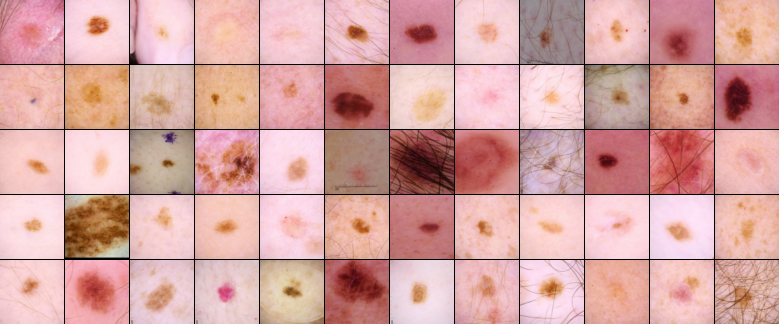

In [24]:
# Train Data
ds = gets_dataset(train_files, PARAMS).unbatch().take(12*5) # augment = False
shows_dataset(64, 12, 5, ds)

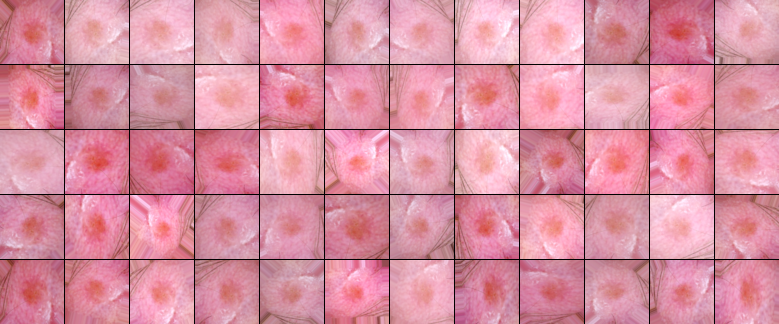

In [25]:
# Image Augmentation
ds = tf.data.TFRecordDataset(train_files, num_parallel_reads=AUTO)
ds = ds.take(1).cache().repeat()
ds = ds.map(tfrecord_labeled_read, num_parallel_calls=AUTO)
ds = ds.map(lambda img, target: (prepare_image(img, cfg=PARAMS, augment=True), target), num_parallel_calls=AUTO)
ds = ds.take(12*5)
ds = ds.prefetch(AUTO)
shows_dataset(64, 12, 5, ds)

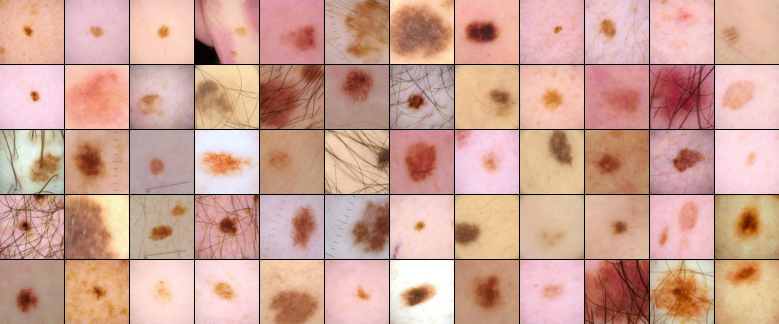

In [26]:
# Test Data
ds = gets_dataset(files_test, PARAMS, labeled=False).unbatch().take(12*5)
shows_dataset(64, 12, 5, ds)

### Fit the model

In [27]:
ds_train = gets_dataset(train_files, PARAMS, augment=True, shuffle=True, repeat=True)
ds_train = ds_train.map(lambda img, label: (img, tuple([label])))
steps_train = count_items(train_files) / (PARAMS['batch_size'] * REPLICAS)

In [28]:
# ds_valid = gets_dataset(valid_files, PARAMS, augment=True, shuffle=False, repeat=False)
model_B7 = compile_model(PARAMS, 'EfficientNetB7')
print("\n Begin Training Models")
# model_B7.summary()
history_B7 = model_B7.fit(ds_train, verbose=1, steps_per_epoch=steps_train, epochs = PARAMS['epochs'], callbacks=[obt_lr_callback(PARAMS)]) 
print("\n Done Training model_B7 \n")

258441216/258434480 [==============================] - 2s 0us/step
Model: "aNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imgIn (InputLayer)           [(None, 248, 248, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 248, 248, 3)       0         
_________________________________________________________________
efficientnet-b7 (Functional) (None, 2560)              64097680  
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,241
Trainable params: 63,789,521
Non-trainable params: 310,720
_________________________________________________________________

 Begin Training Models
Epoch 1/13
255/255 [==============================] - 225s 268ms/step - loss: 0.6570 - auc: 0.4986
Epoch 2/13
255/255 [============================

In [29]:
# Save model:
model_B7.save(f"./EfficientNetB7_{image_dim}x{image_dim}_{year_data}_epoch{PARAMS['epochs']}_auc_{round(history_B7.history['auc'][PARAMS['epochs']-1], 2)}.h5")

# Serialize model architecture to JSON:
model_json = model_B7.to_json()
with open(f"./EfficientNetB7_{image_dim}x{image_dim}_{year_data}_epoch{PARAMS['epochs']}_auc_{round(history_B7.history['auc'][PARAMS['epochs']-1], 2)}_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to h5:
model_B7.save_weights(f"./EfficientNetB7_{image_dim}x{image_dim}_{year_data}_epoch{PARAMS['epochs']}_auc_{round(history_B7.history['auc'][PARAMS['epochs']-1], 2)}_weights.h5")

### Acknowledgements & Inspiration:
* https://www.kaggle.com/vbhargav875/efficientnet-b5-b6-b7-tf-keras
* https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
* https://www.kaggle.com/nroman/melanoma-pytorch-starter-efficientnet?scriptVersionId=40165150
* https://www.kaggle.com/graf10a/siim-data-augmentation-in-tf-hair-batch-affine
* https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords